In [1]:
# ====================================
# Notebook 3: Learning Product Representations from Purchase Behavior
# Description:
# This notebook learns item embeddings from a user-item matrix using SVD + UMAP,
# clusters items with DBSCAN and HDBSCAN, and analyzes clusters by categories and naming patterns.
# ====================================

In [2]:
import os

# === Clone GitHub repository ===
repo_dir = "My-BS-Thesis"

if os.path.exists(repo_dir):
    print(f"{repo_dir} already exists. Removing it...\n")
    !rm -r {repo_dir}

!git clone https://github.com/Goshmar/My-BS-Thesis

Cloning into 'My-BS-Thesis'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 125 (delta 41), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 200.97 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (20/20), done.


In [14]:
# === Install dependencies from requirements.txt ===
!pip install -r My-BS-Thesis/requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.6/461.6 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.6/358.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
import json
import pickle
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from tqdm import tqdm
from scipy.sparse import load_npz
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, label, center_of_mass
from mpl_toolkits.mplot3d import Axes3D
import umap
import hdbscan

In [7]:
# === Set paths ===
data_raw = os.path.join(repo_dir, 'data', 'raw')
data_interim = os.path.join(repo_dir, 'data', 'interim')
processed_data = os.path.join(repo_dir, 'data', 'processed')
artifacts_dir = os.path.join(repo_dir, 'artifacts')
visualizations_dir = os.path.join(artifacts_dir, 'visualizations')

os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(visualizations_dir, exist_ok=True)

matrix_path = os.path.join(processed_data, 'user_item_binary_matrix.npz')
map_path = os.path.join(artifacts_dir, 'mapping.pkl')

id_map_path = os.path.join(data_raw, 'id_mapping.json')

products_output_path = os.path.join(data_interim, 'labeled_products_by_behavior.csv')
products_zip_path = os.path.join(data_interim, 'labeled_products_by_behavior.zip')

In [8]:
# === Load data ===
user_item_matrix = load_npz(matrix_path)
print("✅ User-item matrix loaded.")

with open(map_path, 'rb') as f:
    mappings = pickle.load(f)
item_map = mappings["item_map"]
reverse_item_map = mappings["reverse_item_map"]

with open(id_map_path, "r", encoding="utf-8-sig") as f:
    id_mappings = json.load(f)

name_dict = {v: k for k, v in id_mappings["name_dict"].items()}
group_dict = {v: k.split(" \\ ")[0]  for k, v in id_mappings["group_dict"].items()}

✅ User-item matrix loaded.


In [9]:
# === Power category tree (expert heuristic rules) ===
def get_power_group(group):
    h0 = group.split(" \\ ")[0]
    if h0 in ["САД И ДАЧА", "ТЕПЛЫЕ ПОЛЫ", "противопожарная дверь 860*2050 L"] or len(group.split(" \\ ")) == 1:
        return h0

    h1 = group.split(" \\ ")[1]

    if h0 in ["БАКАЛЕЯ", "ЛАКОКРАСКА"]:
        return h1

    if h0 in ["ИНЖЕНЕРНАЯ САНТЕХНИКА"]:
        if len(group.split(" \\ ")) > 2:

            h2 = group.split(" \\ ")[2]
            if h1 in ["ВОДОСНАБЖЕНИЕ", "ПОЛОТЕНЦЕСУШИТЕЛИ", "ТРУБЫ и ФИТИНГИ"]:
                return h2
            if h2 in ["Комплектующие к радиаторам"]:
                return h2
    if h0 in ["ИНСТРУМЕНТ"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 in ["ПИСТОЛЕТЫ"]:
                return h2
            if h1 in ["РАСХОДНЫЕ МАТЕРИАЛЫ И ОСНАСТКА"]:
                return group.split(" \\ ")[-2]
    if h0 in ["ИНТЕРЬЕР"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 in ["СТЕНОВЫЕ ПАНЕЛИ И ОБОИ", "ДВЕРИ и КОМПЛЕКТУЮЩИЕ"]:
                return h2
            if h2 in ["СРЕДСТВА ДЛЯ РЕСТАВРАЦИИ ПОЛА", "ПОРОГИ", "ПОДЛОЖКА", "Двери Балконные (Под заказ)",
                      "Двери МЕТАЛЛИЧЕСКИЕ", "Двери Уценка", "Двери скрытого монтажа INVISIBLE",
                      "Фурнитура дверна", "Фурнитура мебельная", "КАФЕЛЬ/КЕРАМОГРАНИТ"]:
                return h2

        if len(group.split(" \\ ")) > 3:
            h3 = group.split(" \\ ")[3]
            if h3 in ["ОБЛИЦОВКА", "НАПОЛЬНАЯ"]:
                return h3
            if h2 in ["КОВРОЛИН и КОВРИКИ", "НАПОЛЬНАЯ ПЛИТКА", "ПЛИНТУС",
                      "ЛИНОЛЕУМ", "ЛАМИНАТ"]:
                if h3 in ["Под заказ"]:
                    return h2
                return group.split(" \\ ")[-2]
    if h0 in ["КРЕПЕЖ"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 in ["ШУРУПЫ"]:
                return h2
    if h0 in ["НАРУЖНЫЕ РАБОТЫ"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 in ["МЕТАЛЛОПРОКАТ"]:
                return h2
    if h0 in ["ПЕНА И  КЛЕЙ"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 in ["Клей", "ПЕНА МОНТАЖНАЯ"]:
                return h2
    if h0 in ["САНТЕХНИКА"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 in ["ФАЯНС - ВАННЫ - ПОДДОНЫ", "ВЕНТИЛЯЦИОННЫЕ КАНАЛЫ", "ЛЮЧКИ, РЕШЕТКИ",
                      "ДУШ КАБИНЫ и КОМПЛ", "МЕБЕЛЬ ДЛЯ ВАННЫХ КОМНАТ", "ОТОПИТЕЛЬНОЕ ОБОРУДОВАНИЕ"]:
                return h2
            if h1 in ["СМЕСИТЕЛИ"]:
                return group.split(" \\ ")[-2]
        if h1 in ["Под заказ"]:
            return h0
    if h0 in ["СТРОЙКА"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h1 not in ["ФАНЕРНО-ПЛИТНЫЙ МАТЕРИАЛ"]:
                return h2
    if h0 in ["ЭЛЕКТРИКА"]:
        if len(group.split(" \\ ")) > 2:
            h2 = group.split(" \\ ")[2]
            if h2 in ["Лампы", "Светильник светодиодный"]:
                return h2
            if len(group.split(" \\ ")) > 3:
                h3 = group.split(" \\ ")[3]
                if h2 in ["Эл/фурнитура"]:
                      return h3

    return h1

# Test-check:
# print(get_power_group("ИНТЕРЬЕР \\ НАПОЛЬНЫЕ ПОКРЫТИЯ \\ ПЛИНТУС \\ ПЛИНТУС T-PLAST, 2,2 м  (Россия) серия \"ЧАЙКА\" \\ Акация винтажная   095 \\ Плинтус T-Plast 095 Акация винтажная 2,2м 1/40/42"))
# print(get_power_group("ИНЖЕНЕРНАЯ САНТЕХНИКА \\ РАДИАТОРЫ отопления \\ Радиаторы Royal Thermo \\ Радиатор Royal Thermo BiLiner 500-4 Noir Sable"))
# print(get_power_group("ИНЖЕНЕРНАЯ САНТЕХНИКА \ РАДИАТОРЫ отопления \ Комплектующие к радиаторам \ Комплект плоских кронштейнов с дюбелями 7,2x170мм черн."))
# print(get_power_group("ИНСТРУМЕНТ \\ ЭЛЕКТРОИНСТРУМЕНТ \\ Лобзик \\ Лобзик   MAKITA 4329  450Вт"))
# print(get_power_group("ИНСТРУМЕНТ \\ ПИСТОЛЕТЫ \\ Пистолеты для монтажной пены \\ я/Пистолет для монт.пены с тефлон ТИТАН"))
# print(get_power_group("ИНТЕРЬЕР \\ Фартуки кухонные \\ Фартуки кухонные (АВС,ПВХ пластик) \\ Кухонный фар0 х 1,5мм лак"))
# print(get_power_group("ИНТЕРЬЕР \\ СТЕНОВЫЕ ПАНЕЛИ И ОБОИ \\ УГОЛКИ И МОЛДИНГИ ПВХ \\ Уголки ПВХ белые, молдинги оконные \\ Уголок ПВХ 50х50мм 2,7м белый  1/25"))
# print(get_power_group("ИНТЕРЬЕР \\ СТЕНОВЫЕ ПАНЕЛИ И ОБОИ \\ ОБОИ \\ Обои флизелиновые PRACTIC \\ Обои п/покраску 1,06*10м Practic арт. 1002-10 (1/9)"))
# print(get_power_group("ИНТЕРЬЕР \\ НАПОЛЬНЫЕ ПОКРЫТИЯ \\ ЛИНОЛЕУМ \\ БЫТОВОЙ и ПОЛУКОММЕРЧЕСКИЙ \\ Линолеум 3 м \\ Линолеум Мастер ГЛОСТЕР 4, п/ком., 3м/2мм,0,4мм Profi"))
# print(get_power_group("ИНТЕРЬЕР \\ ДВЕРИ и КОМПЛЕКТУЮЩИЕ \\ Фурнитура дверная \\ Ручки RUCETTI \\ Никель/хром \\ белый никель/хром \\ Ручка дверная Rucetti RAP 11-S SN/CP белый никель/хром"))
# print(get_power_group("ИНТЕРЬЕР \\ НАПОЛЬНЫЕ ПОКРЫТИЯ \\ КАФЕЛЬ/КЕРАМОГРАНИТ \\ ОБЛИЦОВКА, НАПОЛЬНАЯ \\ ОБЛИЦОВОЧНАЯ \\ Плитка облиц. 250х400*8 Зеленая ,Fiori PizaRosa"))
# print(get_power_group("КРЕПЕЖ \\ ШУРУПЫ \\ Шурупы универсальные \\ Шуруп фасовка универс с пот. гол. желт.  4 х 60  (40шт)  Партнер"))
# print(get_power_group("КРЕПЕЖ \\ ТАКЕЛАЖ \\ зажимы и соединители \\ Зажим троса DUBLEX Zn D 2 (1шт) Партнер"))
# print(get_power_group("НАРУЖНЫЕ РАБОТЫ \\ МЕТАЛЛОПРОКАТ \\ Сетка строительная, проволока вязальная \\ Сетка рабица \\ Сетка-рабица 25х25х2мм  2х10м оцинкованная"))
# print(get_power_group("НАРУЖНЫЕ РАБОТЫ \\ ФАСАД \\ Сендвич панели и комплектующие \\ Кровельная панель Т=150"))
# print(get_power_group("САНТЕХНИКА \\ ФАЯНС - ВАННЫ - ПОДДОНЫ \\ Унитазы \\ унитазы косой выпуск \\ Унитаз компакт ЭЛЕГАНТ ROSA (черный кракелюр)"))
# print(get_power_group("САНТЕХНИКА \\ СМЕСИТЕЛИ \\ КОМПЛЕКТУЮЩИЕ К СМЕСИТЕЛЮ \\ Шланги и лейки для душа  \\ Лейка душевая 1 режим 65мм С-157 хедр (582-010)"))
# print(get_power_group("САНТЕХНИКА \\ СМЕСИТЕЛИ \\ Душевая система  \\ Стойка душевая САНАКС (массажная лейка, мыльница) 00001"))
# print(get_power_group("СТРОЙКА \\ ТЕПЛО ЗВУКО ГИДРО ИЗОЛЯЦИЯ \\ Звукоизоляция \\ Звукоизоляция МАКСФОРТЕ ЭкоАкустик 1200*600*50мм (2,88м2, 4 плиты) АНАЛОГ ШУМАНЕТ-ЭКО"))
# print(get_power_group("СТРОЙКА \\ ФАНЕРНО-ПЛИТНЫЙ МАТЕРИАЛ \\ Цементно-стружечные плиты (ЦСП) \\ ЦСП   3200х1250х8мм "))
# print(get_power_group("ЭЛЕКТРИКА \\ ЭЛЕМЕНТЫ ПИТАНИЯ \\ GP \\ Элемент питания 2025 GP (1)"))
# print(get_power_group("ЭЛЕКТРИКА \\ ЭЛЕКТРОУСТАНОВОЧНЫЕ ИЗДЕЛИЯ \\ Эл/фурнитура \ Под скрытую проводку \\ SE \\ ATLAS DESIGN \\ Сталь \\ Переключатель SE ATLAS 1кл., б/р, сталь"))

full_group_dict = {v: get_power_group(k) for k, v in id_mappings["group_dict"].items()} # Top-level group like 'СТРОЙКА'

In [11]:
# === Dimensionality reduction ===
svd = TruncatedSVD(n_components=100, random_state=42)
item_embeddings = svd.fit_transform(user_item_matrix.T)
item_embeddings = normalize(item_embeddings)
print(f"✅ SVD complete. Shape: {item_embeddings.shape}")

✅ SVD complete. Shape: (12881, 100)


In [12]:
# === Create product DataFrame ===
products_df = pd.DataFrame(list(item_map.keys()), columns=["encoded_id"])
products_df["product_name"] = products_df["encoded_id"].map(name_dict)
products_df["category"] = products_df["encoded_id"].map(group_dict)
products_df["full_category"] = products_df["encoded_id"].map(full_group_dict)

print(f"✅ Download {len(products_df)} products.")

✅ Download 12881 products.


In [13]:
# === UMAP ===
umap_reducer = umap.UMAP(n_components=2, metric="cosine", random_state=39)
item_2d = umap_reducer.fit_transform(item_embeddings)
products_df["umap_1"] = item_2d[:, 0]
products_df["umap_2"] = item_2d[:, 1]

# Select a sample
sample_size = min(len(item_2d), len(products_df))
sample_indices = np.random.choice(len(products_df), sample_size, replace=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


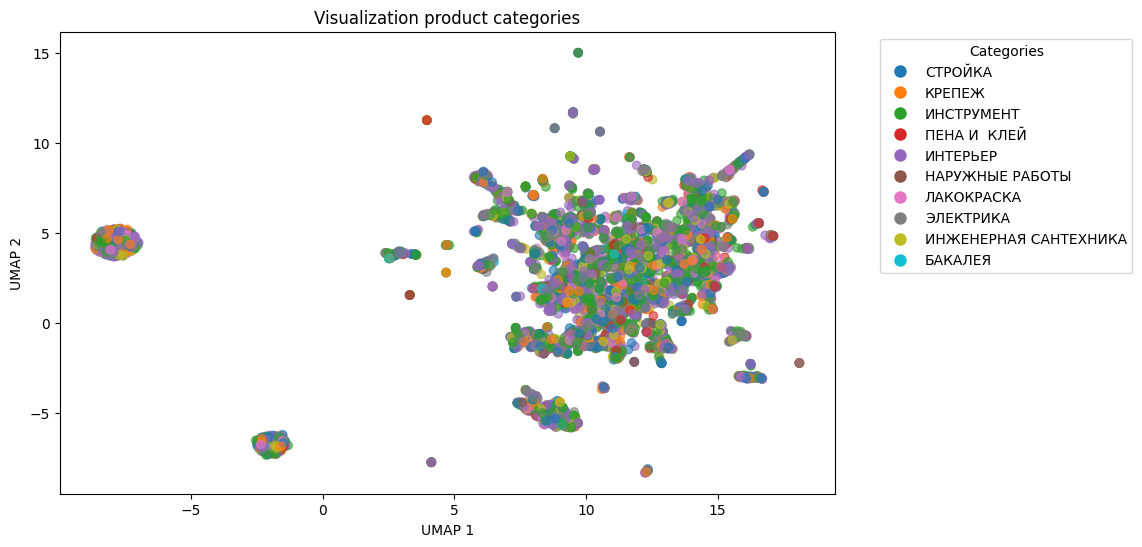

In [18]:
# === Visualization product categories ===
categories = products_df["category"].unique()
color_palette = list(mcolors.TABLEAU_COLORS.values())[: len(categories)]
category_to_color = {cat: color_palette[i % len(color_palette)] for i, cat in enumerate(categories)}

sample_categories = products_df["category"].iloc[sample_indices]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    item_2d[:, 0],
    item_2d[:, 1],
    c=[category_to_color[cat] for cat in sample_categories],
    alpha=0.6
)
plt.title("Visualization product categories")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10) for color in color_palette]
plt.legend(handles, categories, title="Categories", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(os.path.join(visualizations_dir, "umap_product_categories.png"), dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# === DBSCAN clustering ===
dbscan = DBSCAN(eps=0.87, min_samples=60, metric="euclidean")
dbscan_clusters = dbscan.fit_predict(item_2d)
products_df["dbscan_cluster"] = dbscan_clusters

# Determining the number of unique clusters
n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)  # -1 is noise

print(f"✅ DBSCAN identified {n_clusters} clusters (and {list(dbscan_clusters).count(-1)} noise points)")

✅ DBSCAN identified 10 clusters (and 243 noise points)


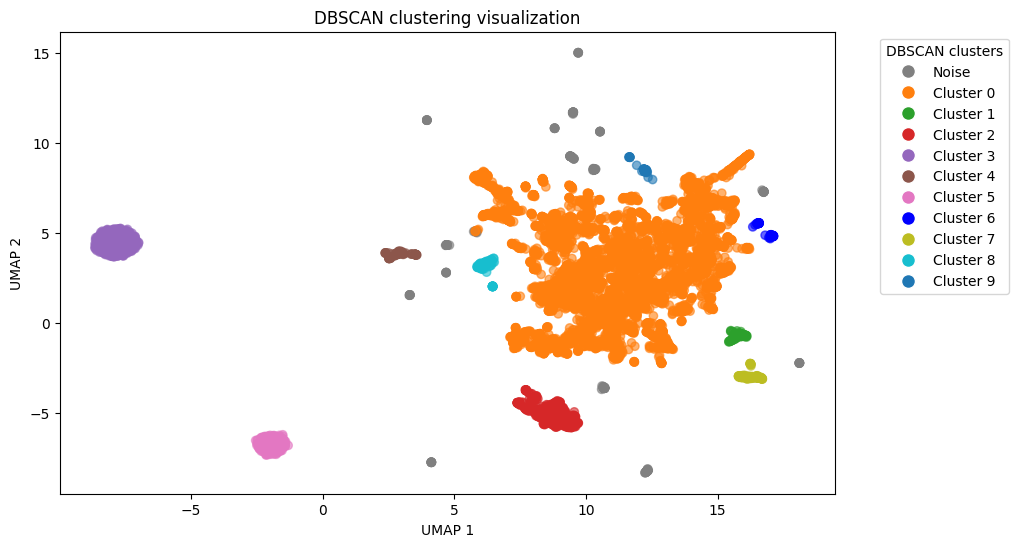

In [20]:
# === DBSCAN clustering visualization ===
unique_clusters = np.unique(dbscan_clusters)
color_palette = list(mcolors.TABLEAU_COLORS.values())[: len(unique_clusters)]
cluster_to_color = {cluster: color_palette[i % len(color_palette)] for i, cluster in enumerate(unique_clusters)}
cluster_to_color[-1] = "gray"
cluster_to_color[6] = "blue"

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    products_df["umap_1"],
    products_df["umap_2"],
    c=[cluster_to_color[cluster] for cluster in products_df["dbscan_cluster"]],
    alpha=0.6
)
plt.title("DBSCAN clustering visualization")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10)
           for cluster, color in cluster_to_color.items()]
labels = [f"Cluster {cluster}" if cluster != -1 else "Noise" for cluster in cluster_to_color.keys()]
plt.legend(handles, labels, title="DBSCAN clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(os.path.join(visualizations_dir, "dbscan_clustering.png"), dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# === Analyze top-10 clusters and their top-3 group of nomenclatures ===
print("\nTop-10 clusters and their top-3 group of nomenclatures")

# Determine non-relevant categories/clusters
excluded_categories = {"ямусор2023", "Транспортные услуги", "", "я", "я-Хознужды, яПескосмесь М-300 25 кг. (ДЛЯ ОПТА)"}
excluded_clusters = {-1}

top_clusters = (

    products_df[~products_df["dbscan_cluster"].isin(excluded_clusters)]["dbscan_cluster"]
    .value_counts()
    .head(10)
    .index.tolist()
)

for cluster in top_clusters:
    cluster_df = products_df[products_df["dbscan_cluster"] == cluster]

    filtered_df = cluster_df[~cluster_df["full_category"].isin(excluded_categories)]

    top_categories = filtered_df["full_category"].value_counts().head(3)

    print(f"\n- Cluster {cluster} ({len(filtered_df)} products):")
    print("top-3 groups of nomenclatures:")

    for category, count in top_categories.items():
        print(f" - {category}: {count} products")


Top-10 clusters and their top-3 group of nomenclatures

- Cluster 0 (8247 products):
top-3 groups of nomenclatures:
 - ИНСТРУМЕНТ МАЛЯРНО-ШТУКАТУРНЫЙ: 258 products
 - Затирки для кафеля: 237 products
 - ИНСТРУМЕНТ ДЛЯ ПОКРАСОЧНЫХ РАБОТ: 198 products

- Cluster 3 (1944 products):
top-3 groups of nomenclatures:
 - СИЛОВОЕ И КОММУТАЦИОННОЕ ОБОРУДОВАНИЕ: 72 products
 - ЭЛЕКТРОИНСТРУМЕНТ: 66 products
 - Двери МЕТАЛЛИЧЕСКИЕ: 59 products

- Cluster 5 (1060 products):
top-3 groups of nomenclatures:
 - ВОДОНАГРЕВАТЕЛИ: 51 products
 - Унитазы: 49 products
 - Электрические полотенцесушители: 39 products

- Cluster 2 (655 products):
top-3 groups of nomenclatures:
 - ПОЛИПРОПИЛЕН: 88 products
 - КАНАЛИЗАЦИЯ раструбная (ПОЛЬША): 71 products
 - Резьбовые соединения: 47 products

- Cluster 7 (158 products):
top-3 groups of nomenclatures:
 - В/д краска: 58 products
 - Декоративные покрытия д/стен: 20 products
 - Колер цветной: 19 products

- Cluster 1 (156 products):
top-3 groups of nomenclatures:
 - 

In [23]:
# === Bag of Words (BoW) statistics ===
print("\nAnalyze top-3 words in each of the 10 largest clusters")
vectorizer = CountVectorizer(stop_words="english")

for cluster in top_clusters:
    cluster_df = products_df[products_df["dbscan_cluster"] == cluster]
    product_names = cluster_df["product_name"].dropna().tolist()

    if product_names:
        bow_matrix = vectorizer.fit_transform(product_names)
        word_counts = np.asarray(bow_matrix.sum(axis=0)).flatten()
        words = np.array(vectorizer.get_feature_names_out())

        filtered_words = [(word, count) for word, count in zip(words, word_counts) if len(word) > 3]

        top_words = sorted(filtered_words, key=lambda x: x[1], reverse=True)[:3]

        print(f"\nCluster {cluster}:")
        for word, count in top_words:
            print(f" - {word}: {count} times")


Analyze top-3 words in each of the 10 largest clusters

Cluster 0:
 - белый: 348 times
 - партнер: 313 times
 - линолеум: 309 times

Cluster 3:
 - дверь: 140 times
 - линолеум: 99 times
 - белый: 92 times

Cluster 5:
 - смеситель: 84 times
 - белый: 58 times
 - рычажный: 51 times

Cluster 2:
 - смеситель: 54 times
 - муфта: 43 times
 - кран: 38 times

Cluster 7:
 - аура: 40 times
 - моющаяся: 29 times
 - aura: 24 times

Cluster 1:
 - смеситель: 14 times
 - кухни: 10 times
 - эмаль: 10 times

Cluster 8:
 - линолеум: 74 times
 - tarkett: 21 times
 - синтерос: 15 times

Cluster 4:
 - напиток: 31 times
 - энерг: 19 times
 - bull: 15 times

Cluster 6:
 - обои: 13 times
 - 25кг: 10 times
 - practic: 10 times

Cluster 9:
 - колорант: 14 times
 - indo70: 6 times
 - жирона: 6 times


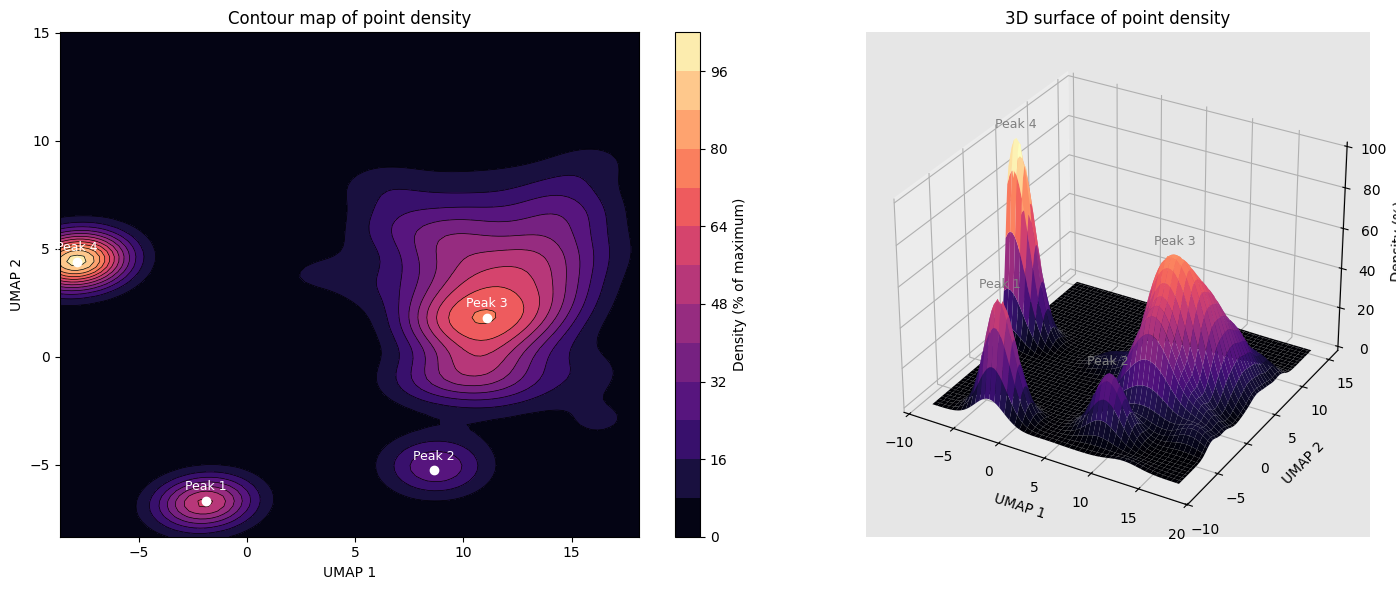

In [25]:
# === Visualization density map ===
x = products_df['umap_1']
y = products_df['umap_2']

# KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)
Z_percent = (Z / Z.max()) * 100  # density in %

# Let's find local max of the density
Z_smooth = maximum_filter(Z_percent, size=3)
local_max = (Z_percent == Z_smooth) & (Z_percent > 10)
labeled, _ = label(local_max)
centroids = center_of_mass(Z_percent, labeled, range(1, labeled.max() + 1))

fig = plt.figure(figsize=(15, 6))
# Left plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor('#e6e6e6')
contourf = ax1.contourf(X, Y, Z_percent, levels=15, cmap='magma')
ax1.contour(X, Y, Z_percent, levels=15, colors='black', linewidths=0.5)
for i, (cy, cx) in enumerate(centroids):
    ax1.plot(x_grid[int(cx)], y_grid[int(cy)], 'wo')
    ax1.annotate(f'Peak {i+1}', (x_grid[int(cx)], y_grid[int(cy)] + 0.5),
                 color='white', fontsize=9, ha='center')
ax1.set_title("Contour map of point density")
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")
cbar = fig.colorbar(contourf, ax=ax1, label='Density (% of maximum)')

# Right plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_facecolor('#e6e6e6')
surf = ax2.plot_surface(X, Y, Z_percent, cmap='magma', edgecolor='none', antialiased=True)
for i, (cy, cx) in enumerate(centroids):
    x_peak = x_grid[int(cx)]
    y_peak = y_grid[int(cy)]
    z_peak = Z_percent[int(cy), int(cx)]
    ax2.text(x_peak, y_peak, z_peak + 5, f'Peak {i+1}', color='gray', fontsize=9, ha='center')

ax2.set_title("3D surface of point density")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
ax2.set_zlabel("Density (%)")
plt.savefig(os.path.join(visualizations_dir, "density_contour_3d_surface.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()

In [27]:
# === HDBSCAN clustering ===
hdb = hdbscan.HDBSCAN(min_cluster_size=250, min_samples=30,
                      metric="euclidean", cluster_selection_method='eom',
                      gen_min_span_tree=True, prediction_data=True)

hdb_clusters = hdb.fit_predict(item_2d)
clusterer = hdb.fit(item_2d)

products_df["hdbscan_cluster"] = hdb_clusters
n_hdb_clusters = len(set(hdb_clusters)) - (1 if -1 in hdb_clusters else 0)
print(f"✅ HDBSCAN identified {n_hdb_clusters} clusters (and {list(hdb_clusters).count(-1)} noise points)")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ HDBSCAN identified 4 clusters (and 266 noise points)


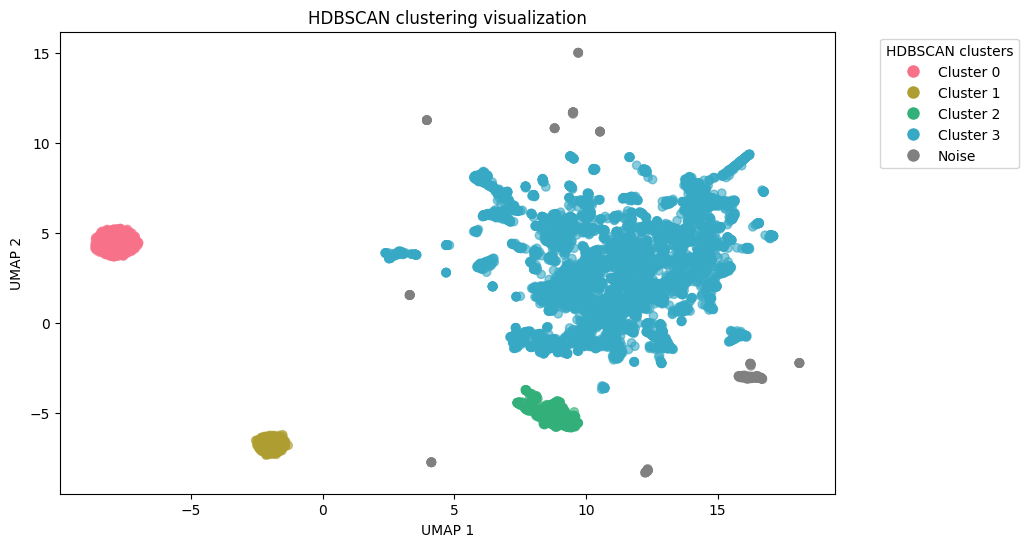

In [28]:
# === HDBSCAN clustering visualization ===
plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl", len(set(hdb_clusters)))
cluster_colors = {cluster: palette[i % len(palette)] for i, cluster in enumerate(set(hdb_clusters))}
cluster_colors[-1] = "gray"

plt.scatter(
    products_df["umap_1"],
    products_df["umap_2"],
    c=[cluster_colors[cluster] for cluster in hdb_clusters],
    alpha=0.6
)
plt.title("HDBSCAN clustering visualization")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
           for cluster, color in cluster_colors.items()]
labels = [f"Cluster {cluster}" if cluster != -1 else "Noise" for cluster in cluster_colors.keys()]
plt.legend(handles, labels, title="HDBSCAN clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(os.path.join(visualizations_dir, "hdbscan_clustering.png"), dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# === Save results ===
products_df.to_csv(products_output_path, index=False)
with zipfile.ZipFile(products_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(products_output_path, arcname=os.path.basename(products_output_path))
os.remove(products_output_path)

print(f"✅ Labeled products saved to: {products_zip_path}")

✅ Labeled products saved to: My-BS-Thesis/data/interim/labeled_products_by_behavior.zip
